# Graph Based Neural Dependency Parser


In [1]:
# Installation Required
!pip install conllu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import Files and Loading Google Drive

In [2]:
from torch.autograd import Variable
import conllu
import pickle
import os
import numpy as np 
from collections import defaultdict
from gensim.models import Word2Vec
import torch
from google.colab import drive

import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

from pickle import load
from matplotlib.pylab import plt
from numpy import arange

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Adjacency Matrix to Maximum Spanning Tree

In [5]:
#make it so there is only one (specified) node reachable in one step from the root
def reduced_graph(graph, root, node):
    new_graph = np.copy(graph)
    nodes_list =  [i for i in range(graph.shape[0])]
    for node1 in nodes_list:
        if node1 == node:
          continue
        new_graph[root][node1] = 0.0
    return new_graph

# returns a list output in which output[i] is parent of node i
def edges_to_single(list_of_edges):
    output = [0] * (len(list_of_edges) + 1)
    for edge in list_of_edges:
        output[edge[1]] = edge[0]
    return output


# returns a adjacency matrix of the non-empty edges in the graph
def get_edges(graph):
    nz=np.nonzero(graph)
    edges=[]
    for i in range(nz[0].shape[0]):
      edges.append((nz[0][i],nz[1][i]))
    return edges

# traverse the path represented by list of edges and returns path cost
def get_path_sum(graph,edges):
    path_sum = 0.0
    for edge in edges:
        path_sum = path_sum + graph[ edge[0] ][ edge[1] ]
    return path_sum

#returns a list of all cycles in the graph, if there is none return empty list
def find_cycles(graph):
    nodes_list =  [i for i in range(graph.shape[0])]
    cycles_list = []
    path = []
    visited = []
    def visit(node):
        if node in visited:
            return
        visited.append(node)
        path.append(node)
        neighbours = []
        for node1 in nodes_list:
            if graph[node][node1] != 0.0:
                neighbours.append(node1)
        for neighbour in neighbours:
            if neighbour in path or visit(neighbour):
                cycles_list.append(path.copy())
                cycles_list[-1].append(neighbour)
        path.remove(node)
        return
    for node in nodes_list:
        visit(node)
    return cycles_list

# takes in a graph (adjacency matrix) and root and returns an mst rooted at the root
def edmonds(graph, root):
    conversion_dictionaries_list = []
    graph1=np.copy(graph)
    for i in range(graph.shape[0]):
      graph1[i][i]=0
      graph1[i][root]=0

    while True:
        biggest_indices=np.argmax(graph1,axis=0)
        graph_attempt=np.zeros(graph1.shape)
        for i in range(biggest_indices.shape[0]):
          row=biggest_indices[i]
          col=i
          graph_attempt[row][col] = graph1[row][col]
        cycles = find_cycles(graph_attempt)
        if len(cycles)==0:
            graph1 = graph_attempt
            break
        
        conversion_dict = defaultdict()
        nodes_list = [i for i in range(graph1.shape[0])]
        cycle1 = cycles[0]
        
        new_graph_nodes = []
        contracted_node = "contracted node"
        for node in nodes_list:
            if node not in set(cycle1):
                new_graph_nodes.append(node)

        updated_indices = {}
        for i in range(len(new_graph_nodes)):
            updated_indices[new_graph_nodes[i]] = i

        updated_indices[contracted_node] = len(new_graph_nodes)
       
        new_graph = np.zeros((len(new_graph_nodes) + 1, len(new_graph_nodes) + 1))

        for node1 in new_graph_nodes:
            for node2 in new_graph_nodes:
                new_graph[updated_indices[node1]][updated_indices[node2]] = graph1[node1][node2]

        #    outward edges
        for node2 in new_graph_nodes:
            max_from_cycle = [0.0, ("dummy", "dummy")]
            for node1 in set(cycle1):
                if graph1[node1][node2] > max_from_cycle[0]:
                    max_from_cycle[0] = graph1[node1][node2]
                    max_from_cycle[1] = (node1, node2)
            new_graph[updated_indices[contracted_node]][updated_indices[node2]] = max_from_cycle[0]
            if max_from_cycle[1] != ("dummy", "dummy"):
                conversion_dict[(updated_indices[contracted_node], updated_indices[node2])] = [max_from_cycle[1]]

        #    inward edges
        nodes_in_cycle = list(set(cycle1))
        test_graph = np.zeros((len(nodes_in_cycle), len(nodes_in_cycle)))
        for node1 in range(len(nodes_in_cycle)):
            for node2 in range(len(nodes_in_cycle)):
                test_graph[node1][node2] = graph1[nodes_in_cycle[node1]][nodes_in_cycle[node2]]

        for node1 in new_graph_nodes:
            max_path_score = 0.0
            max_path = list()
            for i in range(0,len(nodes_in_cycle)):
                path_from_node = edmonds(test_graph, i)

                for j in range(0,len(path_from_node)):
                    path_from_node[j] = (nodes_in_cycle[path_from_node[j][0]], nodes_in_cycle[path_from_node[j][1]])
                path_from_node.append((node1, nodes_in_cycle[i]))

                current_path_score = get_path_sum(graph1, path_from_node)
                if current_path_score > max_path_score:
                    max_path_score = current_path_score
                    max_path = path_from_node

            conversion_dict[(updated_indices[node1], updated_indices[contracted_node])] = max_path
            new_graph[updated_indices[node1]][updated_indices[contracted_node]] = max_path_score

        for node1 in new_graph_nodes:
            for node2 in new_graph_nodes:
                conversion_dict[(updated_indices[node1],updated_indices[node2])] = [(node1, node2)]

        #adding backtracking pointers for each recursive layer
        conversion_dictionaries_list.append(conversion_dict)
        graph1 = new_graph

    # backtracking to find edges used in original graph given final contracted mst
    list_of_nodes = get_edges(graph1)
    if len(conversion_dictionaries_list) == 0:
        return list_of_nodes
   
    while len(conversion_dictionaries_list) > 0:
        new_list = []
        for pair in list_of_nodes:
            for node_pair in conversion_dictionaries_list[-1][pair]:  
                new_list.append(node_pair)
        list_of_nodes = new_list
        del conversion_dictionaries_list[-1]
    return list_of_nodes

def get_edmonds(graph1, root):
    graph = np.copy(graph1)
    mst = edmonds(graph, root)
    return mst


#Load the train, test and validation data

In [6]:
def get_train_data(filename):
  with open(filename, "r") as f:
      data = f.read()

  parsed_data = conllu.parse(data)
  sentences = []
  tags=[]
  id=[]
  head=[]
  deprel=[]

  words_set=set()
  tags_set=set()
  dep_set=set()

  words_set.add('<unk>')
  tags_set.add('<unk>')
  dep_set.add('<unk>')

  for sentence in parsed_data:
    s=[]
    t=[]
    i=[]
    h=[]
    d=[]
    for token in sentence:
      s.append(token["form"])
      t.append(token["upos"])
      i.append(token["id"]-1)
      h.append(token["head"]-1)
      d.append(token["deprel"])
    
      words_set.add(token["form"])
      tags_set.add(token["upos"])
      dep_set.add(token["deprel"])
    
    sentences.append(s)
    tags.append(t)
    id.append(i)
    head.append(h)
    deprel.append(d)

  wordToIndex={item:val for val,item in enumerate(words_set)}
  tagToIndex={item:val for val,item in enumerate(tags_set)}
  depToIndex={item:val for val,item in enumerate(dep_set)}

  return sentences,tags,id,head,deprel,wordToIndex,tagToIndex,depToIndex


In [7]:
path='/content/gdrive/MyDrive/nlp_project'
train_sent,train_tag,train_id,train_head,train_deprel,wordToIndex,tagToIndex,depToIndex=get_train_data(path+"/en_atis-ud-train.conllu")


In [8]:
indexToDep = {v: k for k, v in depToIndex.items()}


In [9]:

def get_val_n_test_data(filename,wordToIndex,tagToIndex,depToIndex):
  with open(filename, "r") as f:
      data = f.read()

  parsed_data = conllu.parse(data)
  sentences = []
  tags=[]
  id=[]
  head=[]
  deprel=[]

  
  for sentence in parsed_data:
    s=[]
    t=[]
    i=[]
    h=[]
    d=[]
    for token in sentence:
      i.append(token["id"]-1)
      h.append(token["head"]-1)

      s.append(token["form"] if token["form"] in wordToIndex.keys() else '<unk>')
      t.append(token["upos"] if token["upos"] in tagToIndex.keys() else '<unk>')
      d.append(token["deprel"] if token["deprel"] in depToIndex.keys() else '<unk>')
    
    sentences.append(s)
    tags.append(t)
    id.append(i)
    head.append(h)
    deprel.append(d)


  return sentences,tags,id,head,deprel


In [10]:
val_sent,val_tag,val_id,val_head,val_deprel=get_val_n_test_data(path+"/en_atis-ud-dev.conllu",wordToIndex,tagToIndex,depToIndex)
test_sent,test_tag,test_id,test_head,test_deprel=get_val_n_test_data(path+"/en_atis-ud-test.conllu",wordToIndex,tagToIndex,depToIndex)

In [11]:
len(wordToIndex),len(depToIndex),len(tagToIndex)

(864, 41, 14)

#Sentences to Embedding using Word2Vec

In [12]:
word_embeddings_gensim = Word2Vec(train_sent, vector_size=50, window=5, min_count=1)
pos_embeddings_gensim = Word2Vec(train_tag, vector_size=10, window=5, min_count=1)


In [13]:
pretrained_word_embeddings = np.zeros((len(wordToIndex),50))
pretrained_pos_embeddings = np.zeros((len(tagToIndex),10))

for word,index in wordToIndex.items():
  if word!='<unk>':
    pretrained_word_embeddings[index] = word_embeddings_gensim.wv[word]
  else:
    pretrained_word_embeddings[index] = np.random.uniform(low=-1, high=1, size=50).astype(np.float32)
    
for tag,index in tagToIndex.items():
  if tag!='<unk>':
    pretrained_pos_embeddings[index] = pos_embeddings_gensim.wv[tag]
  else:
    pretrained_pos_embeddings[index] = np.random.uniform(low=-1, high=1, size=10).astype(np.float32)
   
pretrained_word_embeddings =torch.tensor(pretrained_word_embeddings,dtype=torch.float)
pretrained_pos_embeddings =torch.tensor(pretrained_pos_embeddings,dtype=torch.float)



#Defining the Network Class and creating its object 

In [14]:

# create the neural network
class Network(nn.Module):
    
    def __init__(self, w2i, p2i, pretrained_word_embeddings, pretrained_pos_embeddings,
                 len_word_embed, len_pos_embed, len_feature_vec=20, lstm_hidden_size=400,
                 mlp_arc_hidden_size=500, mlp_label_hidden_size=200, n_label=47):

        super(Network, self).__init__()
        self.len_word_embed = len_word_embed
        self.len_pos_embed = len_pos_embed
        self.len_data_vec = len_word_embed + len_pos_embed
        self.len_feature_vec = len_feature_vec
        self.lstm_hidden_size = lstm_hidden_size
        self.mlp_arc_hidden_size = mlp_arc_hidden_size
        self.mlp_label_hidden_size = mlp_label_hidden_size
        self.n_label = n_label
        self.w2i = w2i
        self.p2i = p2i

        # trainable parameters
        self.word_embeddings = torch.nn.Embedding(len(pretrained_word_embeddings), len_word_embed)
        self.word_embeddings.weight = torch.nn.Parameter(pretrained_word_embeddings)
        self.pos_embeddings = torch.nn.Embedding(len(pretrained_pos_embeddings), len_pos_embed)
        self.pos_embeddings.weight = torch.nn.Parameter(pretrained_pos_embeddings)

        self.BiLSTM = torch.nn.LSTM(input_size=self.len_data_vec, hidden_size=self.lstm_hidden_size,
                                    num_layers = 3, dropout=.33, bidirectional=True)

        self.MLP_arc_head_layer1 = torch.nn.Linear(self.lstm_hidden_size * 2, mlp_arc_hidden_size)
        self.MLP_arc_head_layer2 = torch.nn.Linear(mlp_arc_hidden_size, len_feature_vec)
        self.MLP_arc_dep_layer1 = torch.nn.Linear(self.lstm_hidden_size * 2, mlp_arc_hidden_size)
        self.MLP_arc_dep_layer2 = torch.nn.Linear(mlp_arc_hidden_size, len_feature_vec)

        self.MLP_label_head_layer1 = torch.nn.Linear(self.lstm_hidden_size * 2, mlp_label_hidden_size)
        self.MLP_label_head_layer2 = torch.nn.Linear(mlp_label_hidden_size, len_feature_vec)
        self.MLP_label_dep_layer1 = torch.nn.Linear(self.lstm_hidden_size * 2, mlp_label_hidden_size)
        self.MLP_label_dep_layer2 = torch.nn.Linear(mlp_label_hidden_size, len_feature_vec)

        self.MLP_label_classifier_layer1 = torch.nn.Linear(self.len_feature_vec*2, self.len_feature_vec)
        self.MLP_label_classifier_layer2 = torch.nn.Linear(self.len_feature_vec, self.n_label)

        self.U_1 = nn.Parameter(torch.randn(len_feature_vec, len_feature_vec))
        self.u_2 = nn.Parameter(torch.randn(1, len_feature_vec))

        self.arc_loss = []
        self.label_loss = []
        self.total_loss = []
        

    def MLP_arc_head(self, r):
        hidden = F.relu(self.MLP_arc_head_layer1(r))
        h = self.MLP_arc_head_layer2(hidden)
        return h

    def MLP_arc_dep(self, r):
        hidden = F.relu(self.MLP_arc_dep_layer1(r))
        h = self.MLP_arc_dep_layer2(hidden)
        return h

    def MLP_label_head(self, r):
        hidden = F.relu(self.MLP_label_head_layer1(r))
        h = self.MLP_label_head_layer2(hidden)
        return h

    def MLP_label_dep(self, r):
        hidden = F.relu(self.MLP_label_dep_layer1(r))
        h = self.MLP_label_dep_layer2(hidden)
        return h

    def MLP_label_classifier(self, r):
        hidden = F.relu(self.MLP_label_classifier_layer1(r))
        h = self.MLP_label_classifier_layer2(hidden)
        return h

    def forward(self, sequence):
        # read input
        seq_len = len(sequence[0])
        word_sequence = sequence[:,0]
        pos_sequence = sequence[:,1]
        gold_tree = sequence[:,2] if seq_len == 3 else None # if there is no gold tree given, only predict arcs, not labels
        
        # find word embeddings given sequence of indices and construct data vector
        word_embeddings = self.word_embeddings(word_sequence)
        pos_embeddings = self.pos_embeddings(pos_sequence)
        x = torch.cat((word_embeddings, pos_embeddings), 1)
        x = x[:, None, :]  # add an empty y-dimension, because that's how LSTM takes its input

        # initialise hidden state of the LSTM
        hidden_init_1 = torch.zeros(6, 1, self.lstm_hidden_size)
        hidden_init_2 = torch.zeros(6, 1, self.lstm_hidden_size)
        if torch.cuda.is_available:
            hidden_init_1 = hidden_init_1.cuda()
            hidden_init_2 = hidden_init_2.cuda()
        hidden = (autograd.Variable(hidden_init_1), autograd.Variable(hidden_init_2))

        # embed words in their context
        r, _ = self.BiLSTM(x, hidden)

        # "fork in the road"; arcs
        h_arc_head = torch.squeeze(self.MLP_arc_head(r))
        h_arc_dep = torch.squeeze(self.MLP_arc_dep(r))
        adj_matrix = h_arc_head @ self.U_1 @ torch.t(h_arc_dep) + h_arc_head @ torch.t(self.u_2)


        # if we only try to predict arcs (not labels) we will skip this block
        # this occurs during testing        
        pred_labels = None
        if gold_tree is not None:
            h_label_head = torch.squeeze(self.MLP_label_head(r))
            h_label_dep = torch.squeeze(self.MLP_label_dep(r))
            h_label_dep = h_label_dep[gold_tree.data]
            arcs_to_label = torch.cat((h_label_head, h_label_dep),1)
            pred_labels = self.MLP_label_classifier(arcs_to_label)
        return adj_matrix , pred_labels


In [15]:
network = Network(wordToIndex, tagToIndex, pretrained_word_embeddings ,pretrained_pos_embeddings , 50, 10, n_label=len(depToIndex))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters())

if torch.cuda.is_available():
  network=network.cuda()
  criterion=criterion.cuda()

#Train the model using train and validation data

In [16]:
# return the list parents where parent[i] is the index of the parent of the word at index i
# if word is root, it is the parent of itself 
def get_parents(ids,heads):
    sentence_len = len(ids)
    parents= np.zeros(sentence_len)
    for i in range(sentence_len):
      if heads[i]!=-1:                  #not root
        parents[ids[i]]=heads[i]
      else:                             #root
        parents[ids[i]]=ids[i]

    return torch.LongTensor(parents)
 
# Returns loss of training and validation data 
def get_loss( sent, tag, id, head, deprel,network,isTrain):    
  data_len=len(sent)
  arc_loss_per_data = []
  label_loss_per_data = []
  total_loss_per_data = []
  for i in range(data_len):

      network.zero_grad()  # PyTorch remembers gradients. We can forget them now, because we are starting a new sentence

      # prepare targets
      seq_len = len( sent[i])
      gold_tree = get_parents( id[i], head[i])
      arc_target = Variable(gold_tree, requires_grad=False)

      labels_target = torch.LongTensor(seq_len)
      for j,dep in enumerate( deprel[i]):
          labels_target[j] = depToIndex[dep] if dep in depToIndex else depToIndex['<unk>']
      labels_target = Variable(labels_target, requires_grad=False)

      # prepare input
      sequence = torch.LongTensor(seq_len, 3)
      for j in range(seq_len):
          sequence[j,0] = wordToIndex[ sent[i][j]] if sent[i][j] in wordToIndex else wordToIndex['<unk>']
          sequence[j,1] = tagToIndex[ tag[i][j]]   if tag[i][j] in tagToIndex else tagToIndex['<unk>']
          sequence[j,2] = gold_tree[j]
      sequence_var = Variable(sequence)

      # prepare GPU
      if torch.cuda.is_available():
        arc_target = arc_target.cuda()
        labels_target = labels_target.cuda()
        sequence_var = sequence_var.cuda()
      
      # run the network
      adj_mat, labels_pred = network(sequence_var)
      arc_pred = torch.t(adj_mat)  # nn.CrossEntropyLoss() wants the classes in the second dimension
      arc_loss = criterion(arc_pred, arc_target)
      label_loss = criterion(labels_pred, labels_target)
      total_loss = arc_loss + label_loss
     
      # save losses for convergence history
      arc_loss_per_data.append(arc_loss.data.cpu().numpy())
      label_loss_per_data.append(label_loss.data.cpu().numpy())
      total_loss_per_data.append(total_loss.data.cpu().numpy())
      
      # backprop
      if isTrain:                  #back propagate loss for the train data only not for validation data
        total_loss.backward()
        optimizer.step()        
      
  if isTrain:
    network.arc_loss.append(np.mean(arc_loss_per_data))
    network.label_loss.append(np.mean(label_loss_per_data))
    network.total_loss.append(np.mean(total_loss_per_data))

  return np.mean(total_loss_per_data)

In [17]:
fileExist = os.path.exists(path+"/network.pkl")

# Load the model and other files if exists
if fileExist:
  network.load_state_dict(torch.load(path+"/network.pkl")['model'])
  optimizer.load_state_dict(torch.load(path+"/network.pkl")['optimizer'])

  with open(path+'/dicts.pickle', 'rb') as f:
    wordToIndex=pickle.load(f)
    tagToIndex=pickle.load(f)
    depToIndex=pickle.load(f)
    indexToDep=pickle.load(f)
    pretrained_word_embeddings=pickle.load(f)
    pretrained_pos_embeddings=pickle.load(f)

  with open(path+'/losses.pickle', 'rb') as f:
    train_loss=pickle.load(f)
    val_loss=pickle.load(f)

  network.eval()
 
#otherwise train the model
else:
  train_loss=[]
  val_loss=[]
  epochs=20
  data_len=len(train_sent)
  for epoch in range(epochs):
    mean_train_loss_per_data=get_loss(train_sent,train_tag,train_id,train_head,train_deprel,network,True)
    mean_val_loss_per_data=get_loss(val_sent,val_tag,val_id,val_head,val_deprel,network,False)
    train_loss.append(mean_train_loss_per_data)
    val_loss.append(mean_val_loss_per_data)
    print("Epoch: ",epoch+1, " mean_train_loss_per_data:",mean_train_loss_per_data," mean_val_loss_per_data:",mean_val_loss_per_data)
     
  
  #save the model and other files
  state = {'model': network.state_dict(), 'optimizer': optimizer.state_dict()}
  torch.save(state, path+'/network.pkl')

  with open(path+'/dicts.pickle', 'wb') as f:
    pickle.dump(wordToIndex,f)
    pickle.dump(tagToIndex,f)
    pickle.dump(depToIndex,f)
    pickle.dump(indexToDep,f)
    pickle.dump(pretrained_word_embeddings,f)
    pickle.dump(pretrained_pos_embeddings,f)


  with open(path+'/losses.pickle', 'wb') as f:
    pickle.dump(train_loss,f)
    pickle.dump(val_loss,f)

      

#Calculate the unlabeled and labeled score for the dependency prediction for the test data 

In [18]:
# returns correct unlabeled predictions and total predictions
def unlabeled_score(pred_tensor, gold_tensor):
    correct = 0
    for i in range(0,len(pred_tensor)):
        if pred_tensor[i] == gold_tensor[i]:
            correct = correct + 1
    return correct, len(pred_tensor)

# returns correct labeled predictions and total predictions
def labeled_score(pred_tensor, gold_tensor, pred_labels, gold_labels):
    correct = 0
    for i in range(0,len(pred_tensor)):
        if pred_tensor[i] == gold_tensor[i] and pred_labels[i] == gold_labels[i]:
            correct = correct + 1
    return correct, len(pred_tensor)

# return the index of root.
# root is the node whose head is -1 
def get_root(heads):
  for i in range(len(heads)):
    if heads[i]==-1:
      return i
  return 0

In [19]:
# test the code
uas_scores = 0
las_scores = 0
arc_count = 0

test_size=len(test_sent)

for i in range(test_size):
  gold_labels = []
  for dep in test_deprel[i]:
    if dep in depToIndex:
      gold_labels.append(depToIndex[dep])
    else:
      gold_labels.append(depToIndex['<unk>'])

  gold_tree = get_parents(test_id[i],test_head[i])
  target = Variable(gold_tree, requires_grad=False)

  sent_len=len(test_sent[i])
  sequence= torch.cuda.LongTensor(sent_len,2)
  for j in range(sent_len):
    
    if test_sent[i][j] in wordToIndex:
      sequence[j,0] = wordToIndex[ test_sent[i][j] ]
    else:
      sequence[j,0] = wordToIndex['<unk>']

    if test_tag[i][j] in tagToIndex:
      sequence[j,1] = tagToIndex[  test_tag[i][j] ]
    else:
      sequence[j,1] = tagToIndex['<unk>'] 
 
  sequence_var = Variable(sequence)
  adj_mat,_ = network(sequence_var)
  adj_mat = F.softmax(torch.t(adj_mat))
  adj_mat = adj_mat.data.cpu().numpy()
  
  
  root_of_tree=get_root(test_head[i])
  pred_edges = get_edmonds(adj_mat.T, root_of_tree)   # you need to change this 0, as 0 is not always the root
  #your root is whose head is -1
  pred_single = edges_to_single(pred_edges)

  sequence_with_label = torch.cuda.LongTensor(sent_len,3)
  for j in range(sent_len):
    if test_sent[i][j] in wordToIndex:
      sequence_with_label[j,0] = wordToIndex[ test_sent[i][j] ]
    else:
      sequence_with_label[j,0] = wordToIndex['<unk>']

    if test_tag[i][j] in tagToIndex:
      sequence_with_label[j,1] = tagToIndex[  test_tag[i][j] ]
    else:
      sequence_with_label[j,1] = tagToIndex['<unk>'] 

    sequence_with_label[j,2] = pred_single[j]
    
  sequence_var = Variable(sequence_with_label)
  adj_mat, predicted_labels = network(sequence_var)
  
  
  pred_labels=torch.argmax(predicted_labels, dim=1)
  pred_tensor = torch.LongTensor(pred_single)

  uas = unlabeled_score(pred_tensor, gold_tree)
  las = labeled_score(pred_tensor, gold_tree, pred_labels, gold_labels)

  uas_scores += uas[0]
  las_scores += las[0]
  arc_count += uas[1]

print("Final Accuracy: ",(uas_scores/arc_count)*100, (las_scores/arc_count)*100)

<ipython-input-19-bc4c4f6574c4>:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  adj_mat = F.softmax(torch.t(adj_mat))


Final Accuracy:  88.67579908675799 83.33333333333334


#Test on your own input

In [20]:


inp_sent=['what', 'is', 'the', 'cost', 'of', 'a', 'round', 'trip', 'flight', 'from', 'pittsburgh', 'to', 'atlanta', 'beginning', 'on', 'april', 'twenty', 'fifth', 'and', 'returning', 'on', 'may', 'sixth']
inp_tag=['PRON', 'AUX', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'PROPN', 'ADP', 'PROPN', 'VERB', 'ADP', 'NOUN', 'NUM', 'ADJ', 'CCONJ', 'VERB', 'ADP', 'NOUN', 'ADJ']
with open(path+"/my_test.conllu", "r") as f:
      data = f.read()
parsed_data = conllu.parse(data)

inp_sent=[]
inp_tag=[]
for sentence in parsed_data:
    for token in sentence:
      inp_sent.append(token["form"] if token["form"] in wordToIndex.keys() else '<unk>')
      inp_tag.append(token["upos"] if token["upos"] in tagToIndex.keys() else '<unk>')

sent_len=len(inp_sent)
sequence= torch.cuda.LongTensor(sent_len,2)
for j in range(sent_len):
    if inp_sent[j] in wordToIndex:
      sequence[j,0] = wordToIndex[ inp_sent[j] ]
    else:
      sequence[j,0] = wordToIndex['<unk>']

    if inp_tag[j] in tagToIndex:
      sequence[j,1] = tagToIndex[  inp_tag[j] ]
    else:
      sequence[j,1] = tagToIndex['<unk>']

sequence_var = Variable(sequence)
adj_mat,_ = network(sequence_var)
adj_mat = F.softmax(torch.t(adj_mat))
adj_mat = adj_mat.data.cpu().numpy()

root_of_tree=0
pred_edges = get_edmonds(adj_mat.T, root_of_tree)  
pred_single = edges_to_single(pred_edges)

sequence_with_label = torch.cuda.LongTensor(sent_len,3)
  
for j in range(sent_len):
  if inp_sent[j] in wordToIndex:
    sequence_with_label[j,0] = wordToIndex[ inp_sent[j] ]
  else:
    sequence_with_label[j,0] = wordToIndex['<unk>']

  if inp_tag[j] in tagToIndex:
    sequence_with_label[j,1] = tagToIndex[  inp_tag[j] ]
  else:
    sequence_with_label[j,1] = tagToIndex['<unk>'] 

  sequence_with_label[j,2] = pred_single[j]

sequence_var = Variable(sequence_with_label)
adj_mat, predicted_labels = network(sequence_var)


pred_labels=torch.argmax(predicted_labels, dim=1)
pred_tensor = torch.LongTensor(pred_single)


print("***************  unlabeled **********************")
for i in range(sent_len):

  print(inp_sent[i],"-->",inp_sent[ int(pred_tensor[i]) ] )
print("*************************************************")


print("*****************  labeled **********************")
for i in range(sent_len):
  print(inp_sent[i],"-->",inp_sent[ int(pred_tensor[i]) ] ,":",indexToDep[ int(pred_labels[i]) ] )
print("*************************************************")






***************  unlabeled **********************
what --> what
is --> what
the --> cost
cost --> what
of --> round
a --> round
round --> trip
trip --> cost
flight --> cost
from --> pittsburgh
pittsburgh --> flight
to --> atlanta
atlanta --> flight
beginning --> flight
on --> april
april --> fifth
twenty --> fifth
fifth --> pittsburgh
and --> returning
returning --> beginning
on --> may
may --> returning
sixth --> may
*************************************************
*****************  labeled **********************
what --> what : root
is --> what : cop
the --> cost : det
cost --> what : nsubj
of --> round : case
a --> round : det
round --> trip : compound
trip --> cost : compound
flight --> cost : nmod
from --> pittsburgh : case
pittsburgh --> flight : nmod
to --> atlanta : case
atlanta --> flight : nmod
beginning --> flight : acl
on --> april : case
april --> fifth : obl
twenty --> fifth : nummod
fifth --> pittsburgh : acl
and --> returning : cc
returning --> beginning : conj
on -->

<ipython-input-20-75cad5e8a2b3>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  adj_mat = F.softmax(torch.t(adj_mat))


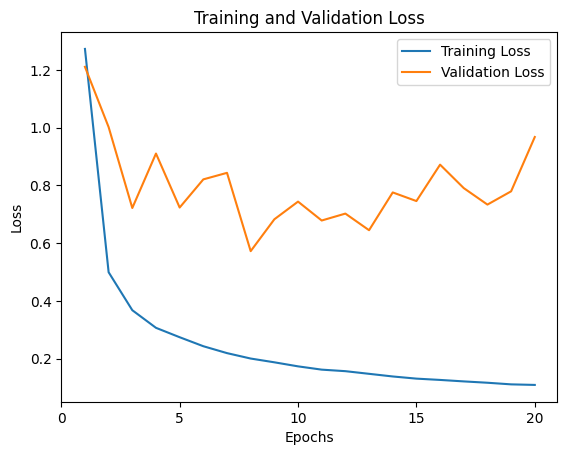

In [21]:

with open(path+'/losses.pickle', 'rb') as f:
    train_loss=pickle.load(f)
    val_loss=pickle.load(f)


# Generate a sequence of integers to represent the epoch numbers
epochs=20
epoch_num = [i+1 for i in range(epochs)]

# Plot and label the training and validation loss values
plt.plot(epoch_num, train_loss, label='Training Loss')
plt.plot(epoch_num, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs+1, 5))

# Display the plot
plt.legend(loc='best')
plt.show()